
# NSMC (네이버 영화평 감정분류) 모델 
## 모델 : LSTM Model

## Dataset
네이버 영화 리뷰 데이터셋<br>

## References
- https://github.com/e9t/nsmc
- http://wikidocs.net/book/2155 (LSTM 분석 부분 참조)

## 개발 환경
Google Corab (With GPU)

## 주의 사항
구글 드라이브 마운트 후 본인 폴더<br>
경로에 맞게 수정이 필요합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 전처리를 위한 konlpy 설치
!pip install konlpy

     |████████████████████████████████| 19.4MB 51.2MB/s 
     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 460kB 29.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
import nltk
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 구글드라이브 연동 -> TXT 파일 다운로드 된 경로를 복사하여 수정해야함.

train_data = pd.read_table('/content/drive/MyDrive/Git Hub/001. KU_202R_NLP_FINAL/NSMC/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Git Hub/001. KU_202R_NLP_FINAL/NSMC/ratings_test.txt')

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
print(len(train_data))

150000


In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True) #document 열에서 중복인 내용은 제거

In [ ]:
print('총 샘플의 수 :', len(train_data))

총 샘플의 수 : 146183


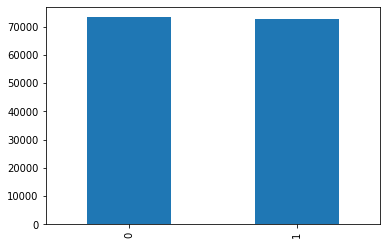

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))  # 라벨 별 사이즈 측정

   label  count
0      0  73342
1      1  72841


In [ ]:
print(train_data.isnull().sum())  #공백 열 찾기

id          0
document    1
label       0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()]  # 공백 열 위치 확인

,id,document,label
25857,2172111,NaN,1


In [ ]:
train_data = train_data.dropna(how = 'any')  #널 값이 존재하는 행 제거
print(train_data.isnull().values.any())  #널 값이 존재하는지 확인

False


In [ ]:
print(len(train_data))

146182


In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
train_data.loc[train_data.document.isnull()] 

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1
...,...,...,...
146607,4602734,NaN,0
147059,7089618,NaN,1
148550,8588827,NaN,0
149358,6780491,NaN,0


In [ ]:
train_data = train_data.dropna(how = 'any')  # 공백 행 제거
print(len(train_data))

145791


In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


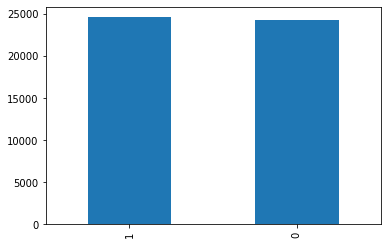

In [ ]:
test_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 처리

In [ ]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from konlpy.tag import Okt

In [ ]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [ ]:
#https://iostream.tistory.com/144 형태소 분석기 모델 분석 비교
#연산 속도가 중요하다면 mecab을 최우선으로 고려해야하며, 심지어 분석 품질도 상위권으로 보여짐


#출처: https://iostream.tistory.com/144 [Almost Baseball, CSE and Diary]

In [ ]:
# Mecab은 윈도우 환경에서 실행이 불가합니다.
# 본 실험은 Mac 환경 아나콘다 3 쥬피터랩에서 실행하였습니다.
# 형태소 분석기 Mecab 사용법

'''
매개 변수:	dicpath – The path of the MeCab-ko dictionary.
morphs(phrase)¶
Parse phrase to morphemes.

nouns(phrase)
Noun extractor.

pos(phrase, flatten=True)
POS tagger.

매개 변수:	flatten – If False, preserves eojeols.'''

In [ ]:
!pip install mecab-python3

In [ ]:
import MeCab

In [ ]:
from konlpy.tag import Mecab

In [ ]:
mecab = Mecab()

In [ ]:
mecab.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

In [ ]:
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = mecab.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)
    
    

In [ ]:
print(X_train[:10])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정'], ['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다'], ['막', '걸음마', '뗀', '세', '부터', '초등', '학교', '학년', '생', '인', '살용', '영화', 'ㅋㅋㅋ', '별반', '개', '아까움'], ['원작', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다'], ['별', '반개', '아깝', '다', '욕', '나온다', '이응경', '길용우', '연기', '생활', '몇', '년', '인지', '정말', '발', '로', '해도', '그것', '보단', '낫', '겟', '다', '납치', '감금', '만', '반복', '반복', '드라마', '가족', '없', '다', '연기', '못', '하', '사람', '만', '모엿', '네'], ['액션', '없', '는데', '재미', '있', '몇', '안', '되', '영화'], ['왜', '케', '평점', '낮', '건데', '꽤', '볼', '만', '한데', '헐리우드', '식', '화려', '함', '만', '너무', '길들여져', '있', '나']]


In [ ]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = mecab.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 50048
등장 빈도가 2번 이하인 희귀 단어의 수: 28427
단어 집합에서 희귀 단어의 비율: 56.79947250639387
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7662526889945191


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21623


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[25, 65, 912, 31, 213, 13, 26, 697], [975, 480, 327, 630, 2, 108, 1549, 46, 788, 950, 9, 36, 366], [17, 190, 1]]


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
y_train

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence)<1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.803762553308571


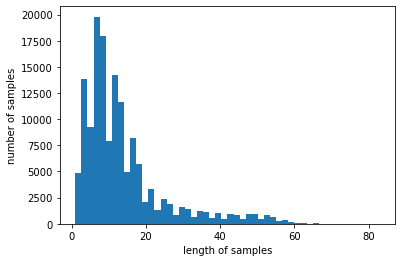

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 94.77025725684413


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
# 학습시키기 직전 단계 까지 완료 함.


In [ ]:
pd.read

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.3877 - acc: 0.8245
Epoch 00001: val_acc improved from -inf to 0.84678, saving model to best_model.h5
1939/1939 [==============================] - 79s 41ms/step - loss: 0.3877 - acc: 0.8245 - val_loss: 0.3514 - val_acc: 0.8468
Epoch 2/15
1939/1939 [==============================] - ETA: 0s - loss: 0.3205 - acc: 0.8619
Epoch 00002: val_acc improved from 0.84678 to 0.85459, saving model to best_model.h5
1939/1939 [==============================] - 77s 40ms/step - loss: 0.3205 - acc: 0.8619 - val_loss: 0.3300 - val_acc: 0.8546
Epoch 3/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.2931 - acc: 0.8772
Epoch 00003: val_acc improved from 0.85459 to 0.86353, saving model to best_model.h5
1939/1939 [==============================] - 76s 39ms/step - loss: 0.2931 - acc: 0.8772 - val_loss: 0.3162 - val_acc: 0.8635
Epoch 4/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.2732 - acc: 0.8876
E

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 10s 6ms/step - loss: 0.3209 - acc: 0.8634

 테스트 정확도: 0.8634


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
    

In [ ]:
def sentiment_predict_csv(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측

In [ ]:
sentiment_predict('이것도 영화라고 만든건가?')

87.82% 확률로 부정 리뷰입니다.



In [ ]:
import pandas as pd

df_test=pd.read_csv("ko_data.csv",header=0, delimiter=",",encoding='CP949')
df_test.head()


,Id,Sentence
0,0,정말 많이 울었던 영화입니다.
1,1,시간 낭비예요.
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.
3,3,지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!
4,4,이걸 영화로 만드는 거야?얼마나 가는지 보자.


0

In [ ]:
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = df_test["sentiment"]

In [ ]:
def sentiment_predict_csv(new_sentence):
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측

    if score > 0.5:
        return 1
    else:
        return 0

In [ ]:

result = []
for index, row in df_test.iterrows():

    result.append(sentiment_predict_csv(row['Sentence']))

    

In [ ]:
print(result[0:5])

[1, 0, 0, 1, 0]


In [ ]:
import pandas as pd
submission = pd.DataFrame()

In [ ]:
import copy
df_sub = copy.deepcopy(df_test)
df_sub["Predicted"] = result
df_sub = df_sub[['Id','Predicted']]
df_sub.to_csv("submission.csv",index=False)

In [ ]:
!head submission.csv

Id,Predicted
0,1
1,0
2,0
3,1
4,0
5,1
6,0
7,1
8,0
